In [3]:
import pandas as pd
import nibabel as nib
from glob import glob
import numpy as np


In [4]:
fc_pattern='results/{dataset}/sub-{subject}/func/sub-{subject}_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_bold.pconn.nii'
sfc_pattern='results/{dataset}/sub-{subject}/func/sub-{subject}_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_sfc.pscalar.nii'


datasets=['HCP','LOBE']



In [5]:
sfc_paths={}
sfc_paths['HCP'] = sorted(glob(sfc_pattern.format(dataset='HCP',subject='*')))
sfc_paths['LOBE'] = sorted(glob(sfc_pattern.format(dataset='LOBE',subject='*')))

fc_paths={}
fc_paths['HCP'] = sorted(glob(fc_pattern.format(dataset='HCP',subject='*')))
fc_paths['LOBE'] = sorted(glob(fc_pattern.format(dataset='LOBE',subject='*')))


print(sfc_paths)
print(fc_paths)

{'HCP': ['results/HCP/sub-HCD0021614/func/sub-HCD0021614_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_sfc.pscalar.nii', 'results/HCP/sub-HCD0026119/func/sub-HCD0026119_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_sfc.pscalar.nii', 'results/HCP/sub-HCD0277447/func/sub-HCD0277447_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_sfc.pscalar.nii'], 'LOBE': ['results/LOBE/sub-007/func/sub-007_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_sfc.pscalar.nii', 'results/LOBE/sub-009/func/sub-009_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_sfc.pscalar.nii', 'results/LOBE/sub-010/func/sub-010_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_sfc.pscalar.nii']}
{'HCP': ['results/HCP/sub-HCD0021614/func/sub-HCD0021614_task-rest_den-32k_desc-preproc_denoise-24HMP8PhysSpikeReg_fwhm-5_atlas-schaefer_bold.p

In [5]:


sfc_nib  = nib.load(sfc_paths['HCP'][0])

In [8]:
sfc_nib.get_fdata().shape


(1, 300)

In [6]:
sfc={}
fc={}
for dataset in datasets:
    sfc[dataset] = np.concatenate(  [ nib.load(path).get_fdata()  for path in sfc_paths[dataset]] ,axis=0)
    fc[dataset] = np.concatenate(  [ nib.load(path).get_fdata()  for path in fc_paths[dataset]] ,axis=0)

In [24]:
sfc.keys()

dict_keys(['HCP', 'LOBE'])

In [11]:
sfc['LOBE'].shape

(3, 300)

In [12]:
fc['LOBE'].shape




(900, 300)

In [89]:
#process single subject

conn = nib.load(fc_paths['HCP'][0]).get_fdata()

In [90]:
atlas_tsv = 'resources/atlas/atlas-{atlas}_dseg.tsv'
df_atlas = pd.read_csv(atlas_tsv.format(atlas='schaefer'),sep='\t',index_col='index')
df_atlas

,name,color,x,y,z,networks
index,,,,,,
1,7Networks_LH_Vis_1,#781184,-33.647,-41.942,-21.283,Vis
2,7Networks_LH_Vis_2,#781185,-30.465,-35.141,-14.832,Vis
3,7Networks_LH_Vis_3,#781186,-34.548,-65.625,-15.514,Vis
4,7Networks_LH_Vis_4,#78127f,-26.215,-54.512,-6.785,Vis
5,7Networks_LH_Vis_5,#781280,-22.869,-74.146,-7.617,Vis
...,...,...,...,...,...,...
296,7Networks_RH_Default_pCunPCC_2,#cc3f4d,17.855,-57.826,20.055,Default
297,7Networks_RH_Default_pCunPCC_3,#cc3f4e,5.351,-51.907,25.747,Default
298,7Networks_RH_Default_pCunPCC_4,#cc3f4f,5.225,-37.302,36.612,Default


In [91]:
network_names = df_atlas.networks.unique()
network_names

array(['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont',
       'Default'], dtype=object)

In [92]:
mask_rows=np.zeros(conn.shape)
mask_cols=np.zeros(conn.shape)

mask_rows[df_atlas.networks == 'Vis',:] = 1
mask_cols[:,df_atlas.networks == 'Vis'] = 1
mask_diag=np.eye(len(conn))


mask_network = mask_rows * mask_cols * (mask_diag==0)
mask_network = mask_network.astype(bool)

#mask_network
mask_network

conn_network = conn[mask_network]



In [93]:
np.sum(df_atlas.networks == 'Vis')

47

In [94]:
47*47-47

2162

In [95]:
conn[df_atlas.networks == 'Vis',df_atlas.networks == 'Default']

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (47,) (68,) 

In [96]:
conn_network = np.zeros((len(network_names),len(network_names)))


for i,net_i in enumerate(network_names):
    for j,net_j in enumerate(network_names):
        mask_rows=np.zeros(conn.shape)
        mask_cols=np.zeros(conn.shape)
        
        mask_rows[df_atlas.networks == net_i,:] = 1
        mask_cols[:,df_atlas.networks == net_j] = 1
        mask_diag=np.eye(len(conn))
        
        
        mask_network = mask_rows * mask_cols * (mask_diag==0)
        mask_network = mask_network.astype(bool)
        
        #mask the net_i x net_j values, and take mean
        conn_vals = conn[mask_network]
        conn_network[i,j] = conn_vals.mean()



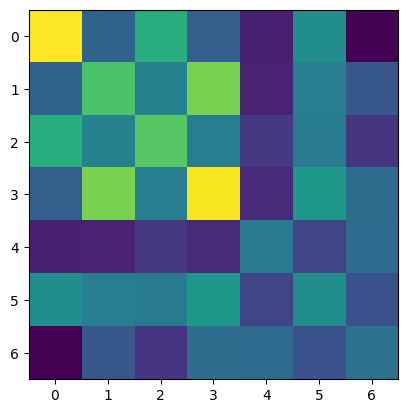

In [97]:
import matplotlib.pyplot as plt
plt.imshow(conn_network)

In [79]:
network_names[3]

'SalVentAttn'

In [99]:
nib_fc = nib.load(fc_paths['HCP'][0])

In [ ]:
parcel_axis = nib_fc.header.get_axis(0)
parcel_axis.vertices

In [130]:
structures = 

for i,net in enumerate(network_names):
    region_indices = np.where(df_atlas.networks == net)[0]

    for structure in ['CIFTI_STRUCTURE_CORTEX_LEFT','CIFTI_STRUCTURE_CORTEX_RIGHT']:
        
        for region in region_indices]
        cortex_left_vertices = [parcel_axis.vertices[region]['CIFTI_STRUCTURE_CORTEX_LEFT'] for region in region_indices] 
    
    break

KeyError: 'CIFTI_STRUCTURE_CORTEX_LEFT'

In [129]:
region_indices = df_atlas.networks == 'Vis'
np.where(region_indices)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172])

In [120]:
len(parcel_axis.vertices)
left_parcel_axis.vertices[0]

{'CIFTI_STRUCTURE_CORTEX_LEFT': array([22694, 22695, 22722, 22723, 22724, 22725, 22726, 22748, 22749,
        22750, 22751, 22752, 22753, 22754, 22755, 22756, 22757, 22773,
        22774, 22775, 22776, 22777, 22778, 22779, 22780, 22781, 22782,
        22783, 22784, 22799, 22800, 22801, 22802, 22803, 22804, 22805,
        22806, 22807, 22808, 22809, 22810, 22824, 22825, 22826, 22827,
        22828, 22829, 22830, 22831, 22832, 22833, 22834, 22835, 22848,
        22849, 22850, 22851, 22852, 22853, 22854, 22855, 22856, 22857,
        22858, 22859, 22860, 22872, 22873, 22874, 22875, 22876, 22877,
        22878, 22879, 22880, 22881, 22882, 22883, 22896, 22897, 22898,
        22899, 22900, 22901, 22902, 22903, 22904, 22905, 22918, 22919,
        22920, 22921, 22922, 22923, 22924, 22925, 22926, 22939, 22940,
        22941, 22942, 22943, 22944, 22945, 22946, 22959, 22960, 22961,
        22962, 22963, 22964, 22965, 22978, 22979, 22980, 22981, 22982,
        22983, 22996, 22997, 22998, 22999, 230

In [113]:
network_axis = parcel_axis
network_axis.name = network_names

In [114]:
nib_network = nib.Cifti2Image(conn_network,header=(network_axis,network_axis))

In [116]:
nib_network.to_filename('test_networkfc.pconn.nii')